Script and text from (which may be blocked for you, which is why I copy-pasted it all here): https://medium.com/analytics-vidhya/multi-armed-bandits-part-1-epsilon-greedy-algorithm-with-python-code-534b9e2abc9

_Semantic: each "bandit" can be thought of as an action_

# The Algorithm
The idea behind it is pretty simple. You want to exploit your best option most of the time but you also want to explore a bit in case there’s something even better.\
In our example, every Saturday you would randomly sample a number between 0 and 1. If that number is less than 𝛆 then you pick a restaurant at random, if it is not you pick your favourite restaurant so far. Therefore, 𝛆 defines how much time you will spend exploring new stuff.\
In pseudo-code (and using bandits instead of restaurants):

_Note that this specific bandit algorithm uses Q(At) = Rt, which is different from the example in your notes that uses the Averaging Learning Rule to define the value function_

```
Choose epsilon; # exploration probability
Choose n; # number of iterations
for i = 1 to n do:
  p = pick a random number from 0 to 1 
  if p < epsilon:
       current_bandit = pick bandit at random  # explore
  else:
       current_bandit = pick best bandit so far  # exploit
  reward = current_bandit.pull_arm()
  
  Update estimation for what rewards the current bandit gives
```

OK, that sounds simple enough. How do we pick 𝛆? \
One option would be to set it to a constant value. Possible values could be 0.01, 0.05, 0.1. This, however, means that even after you’ve explored all the possible options a considerable number of times, and therefore have a pretty good idea of what rewards you should expect from each one, you will still spend time doing random stuff. This is like knowing that you hate that pizza restaurant for sure but still giving it a go every now and then. Under the assumption that it hasn’t changed in any way, this would make for an unnecessarily sub-optimal dining experience.
Another option is to make 𝛆 depend on the number of actions (iterations) we’ve taken so far. The idea is as we collect more data we want to reduce the amount of time we spend exploring as we already know what rewards to expect from each bandit. One such strategy is to choose 𝛆 = 1 / #actions.\
# Show Me The Code
Before we start writing code let’s think about how to structure our data. We have Bandits that generate rewards when we pull their arm and we also have an Agent that can interact with them and collect information using a specific approach (e.g. epsilon-greedy).\
The Bandit class defined below will generate rewards according to a Normal distribution.

In [90]:
from uuid import uuid4
import numpy as np
from typing import List, Tuple
import matplotlib
import matplotlib.pyplot as plt
import logging
logger=logging.getLogger()
from collections import defaultdict

Before we start writing code let’s think about how to structure our data. We have Bandits that generate rewards when we pull their arm and we also have an Agent that can interact with them and collect information using a specific approach (e.g. epsilon-greedy).
The Bandit class defined below will generate rewards according to a Normal distribution.

_Ex: If bandit = action 1, m = q*(1), refer to slide 25 of your notes to see the Distribution_

In [91]:
class Bandit:
    def __init__(self,m):
        """
        Stimulates bandit.
        Args:
            m (float): True mean, 0 in class notes
        """
        self.m=m
        self.id=uuid4()
    def pull(self):
        """
        Stimulate pulling the arm of the bandit.
        Normal distribution with mu=self.m and sigma=1
        """
        reward=np.random.randn()+self.m # results in N~(m, 1)
            # np.random.randn() generates a random float sampled from a univariate "normal" distribution
            # with a mean of 0 and variance of 1
        return reward

In [92]:
mean_reward=3
n_samples=50

In [93]:
rewards=[]

In [94]:
for i in range(n_samples):
    test_bandit=Bandit(mean_reward)
    tmp_reward=test_bandit.pull()
    print(f"Bandit ID: {test_bandit}")
    print(f"Bandit reward: {test_bandit.pull()}")
    rewards.append(tmp_reward)

Bandit ID: <__main__.Bandit object at 0x7fbad0629910>
Bandit reward: 4.119516982513705
Bandit ID: <__main__.Bandit object at 0x7fbab0777e80>
Bandit reward: 1.8415102022945804
Bandit ID: <__main__.Bandit object at 0x7fbad0629910>
Bandit reward: 3.1891015921695796
Bandit ID: <__main__.Bandit object at 0x7fbaa0805ee0>
Bandit reward: 3.856857093308798
Bandit ID: <__main__.Bandit object at 0x7fbaa09b63a0>
Bandit reward: 3.8180655675766952
Bandit ID: <__main__.Bandit object at 0x7fbad0619ac0>
Bandit reward: 3.922829278194939
Bandit ID: <__main__.Bandit object at 0x7fbad0619460>
Bandit reward: 2.5699977504942195
Bandit ID: <__main__.Bandit object at 0x7fbad0629c40>
Bandit reward: 3.000982011395991
Bandit ID: <__main__.Bandit object at 0x7fba700e37c0>
Bandit reward: 2.253169363762887
Bandit ID: <__main__.Bandit object at 0x7fbad0619f10>
Bandit reward: 3.157665467468453
Bandit ID: <__main__.Bandit object at 0x7fbad0619430>
Bandit reward: 3.1274457501875426
Bandit ID: <__main__.Bandit object at 

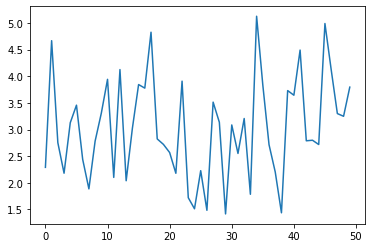

In [95]:
plt.plot(range(n_samples),rewards)

(array([ 6.,  3.,  6., 10.,  6.,  4.,  8.,  2.,  2.,  3.]),
 array([1.41504175, 1.78623411, 2.15742647, 2.52861883, 2.89981119,
        3.27100355, 3.64219591, 4.01338827, 4.38458063, 4.75577299,
        5.12696535]),
 <BarContainer object of 10 artists>)

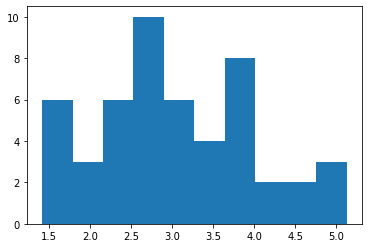

In [96]:
plt.hist(rewards)

Then we define the epsilon-greedy agent class. Given a list of bandits and 𝛆, the agent can choose from where to get rewards in each step:

In [97]:
class EpsilonGreedyAgent:
    def __init__(self, bandits: List[Bandit], epsilon: float = None):
        self.bandits = bandits
        self.epsilon = epsilon
        self.rewards_log = BanditRewardsLog()

    def _get_random_bandit(self) -> Bandit:
        return np.random.choice(self.bandits)

    def _get_current_best_bandit(self) -> Bandit:
        estimates = []
        for bandit in self.bandits:
            bandit_record = self.rewards_log[bandit]
            if not bandit_record['actions']:
                estimates.append(0)
            else:
                estimates.append(bandit_record['reward'] / bandit_record['actions'])

        return self.bandits[np.argmax(estimates)]

    def _choose_bandit(self) -> Bandit:
        epsilon = self.epsilon or 1 / (1 + self.rewards_log.total_actions)

        p = np.random.uniform(0, 1, 1)
        if p < epsilon:
            bandit = self._get_random_bandit()
        else:
            bandit = self._get_current_best_bandit()

        return bandit

    def take_action(self):
        current_bandit = self._choose_bandit()
        reward = current_bandit.pull()
        self.rewards_log.record_action(current_bandit, reward)
        return reward

    def take_actions(self, iter):
        for _ in range(iter):
            self.take_action()

There’s an additional helper class for keeping track of the rewards that were generated from each bandit.

In [98]:
class BanditRewardsLog:
    def __init__(self):
        self.total_actions = 0
        self.total_rewards = 0
        self.all_rewards = []
        self.record = defaultdict(lambda: dict(actions=0, reward=0))

    def record_action(self, bandit, reward):
        self.total_actions += 1
        self.total_rewards += reward
        self.all_rewards.append(reward)
        self.record[bandit.id]['actions'] += 1
        self.record[bandit.id]['reward'] += reward

    def __getitem__(self, bandit):
        return self.record[bandit.id]

In [99]:
    def __init__(self, bandits: List[Bandit], epsilon: float = None):
        self.bandits = bandits
        self.epsilon = epsilon
        self.rewards_log = BanditRewardsLog()

We now have everything we need to run some simulations and see which 𝛆 works better.
# To Exploit or Not To Exploit
It is relatively straightforward to compare the different options for 𝛆 using our code from the previous section.

    agents = []
    bandits = [Bandit(m) for m in bandits_true_means]

In [100]:
def compare_epsilons(
    epsilons: List[float],
    bandits_true_means: List[float],
    iterations: int,
) -> Tuple[List[EpsilonGreedyAgent], List[float]]:
    """
    Compare different epsilons for epsilon-greedy algorithm.
    """
    agents = []
    bandits = [Bandit(m) for m in bandits_true_means]

    for epsilon in epsilons:
        logger.info("Running epsilon-greedy for epsilon = %f", epsilon)
        agent = EpsilonGreedyAgent(bandits=bandits, epsilon=epsilon)
        agent.take_actions(iterations)
        agents.append(agent)

    return agents, epsilons

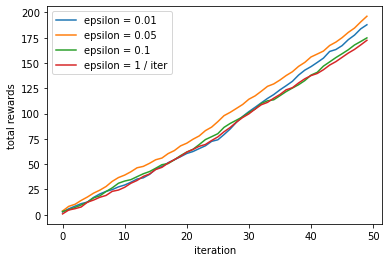

In [101]:
epsilons = [0.01, 0.05, 0.1, 0]
bandits_means = [3, 4, 5]

iterations = 50
agents, _ =  compare_epsilons(epsilons, bandits_means, iterations)

all_rewards = [agent.rewards_log.all_rewards for agent in agents]


for i in range(len(agents)):
    plt.plot(
        np.cumsum(all_rewards[i]), 
        label="epsilon = {}".format(epsilons[i] or '1 / iter'),
    )

plt.xlabel("iteration")
plt.ylabel("total rewards")
plt.legend()
plt.show()

We can see that in this scenario reducing the exploration rate as we collect more data yields the best result. This intuitively makes sense as there’s no reason to continue exploring once we are fairly certain on the kinds of rewards each bandit produces.